# Idea

Statistical arbitrage through pairs trading with cointegrated pairs:
  - Time horizon of data: 4h, 8h, 12h, 24h, 48h
  - Method of identification of cointegrated pairs
      - Fixed set of cointegrated pairs calculated from a training period
      - Dynamically determined cointegrated pairs calculated each period or every several periods
  - Method of hedge-ratio calculation:
      - Pairs with a fixed hedge ratio calculated from a training period
      - Pairs with a dynamic hedge ratio calculated from a look-back period
  - Significance level for being considered cointegrated (rejecting the null hypothesis):
      - 0.10
      - 0.05
      - 0.02
  - Entry and exit levels
  - Lookback window length to calculate z-score (presumably shorter than window to calculate dynamic hedge ratio)


Separate idea:
  - Use price for cointegration or use returns for cointegration
  
  
Also consider baskets instead.

# Methodology

- Select the top cryptocurrencies from December 2020 and use historical price data from December 2020 to December 2023 as a training period. We use data from December 2020 to avoid lookahead bias for our selection of cryptocurrencies in the universe.
- Use the Engle-Granger two-step method to find cointegrated pairs over a trailing window of x weeks (x to be determined from experimentation) with a significance level $\alpha$ to be determined.
- Re-calculate the hedge ratio over periods of y weeks (y to be determined) and trade the spread between pairs of cointegrated coins during the training period.
- Analyze the results over the training period and select the variations of x, y, and $\alpha$ with the highest sharpe ratios (which should hopefully also have manageable maximum drawdown durations). Run those variations during the testing period.

# Results

To be filled in: summarize the key performance metrics you calculated.

# Future Work

To be filled in: mention potential improvements, such as adding more pairs, optimizing entry/exit rules, or incorporating more advanced statistical models like the Kalman filter.

Relevant resources:
  - https://medium.com/@trading.dude/unlocking-the-hidden-potential-using-statistical-arbitrage-as-an-indicator-in-python-a8595392def4

# Imports

In [1]:
# import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from binance.client import Client as bnb_client
from datetime import datetime
from statsmodels.tsa.stattools import coint

from ipynb.fs.full.utility_functions import (
    get_train_test_data,
    get_alpha_beta_to_asset,
    get_gross_returns_and_net_returns,
    get_rank_demeaned_normalized_signal,
    get_strategy_stats,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Get Historical Data For Cryptocurrencies

In [2]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [3]:
client = bnb_client(tld='US')

def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px_popular = px[["BTCUSDT", "ETHUSDT", "LTCUSDT", "XRPUSDT", "ADAUSDT"]]

In [4]:
t = datetime(2024, 1, 1, 0, 0)

popular_train_px, popular_test_px = get_train_test_data(px_popular, t)
full_train_px, full_test_px = get_train_test_data(px, t)

# Utility Functions

## Identifying cointegrated pairs

In [5]:
def find_cointegrated_pairs(data, significance_level=0.05):
    """
    Finds cointegrated pairs using the Engle-Granger two-step method.
    Returns a list of cointegrated pairs with their p-value.
    """
    n = data.shape[1]
    keys = data.columns
    pvalue_matrix = pd.DataFrame(np.ones((n, n)), index=keys, columns=keys)
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            series1 = data[keys[i]]
            series2 = data[keys[j]]
            
            joint_non_na_series1 = series1.loc[series1.notna() & series2.notna()]
            joint_non_na_series2 = series2.loc[series1.notna() & series2.notna()]
            
            if len(joint_non_na_series1) == 0 or len(joint_non_na_series2) == 0:
                pvalue_matrix.loc[keys[i], keys[j]] = 1.0
                continue

            # Perform the cointegration test
            score, pvalue, _ = coint(joint_non_na_series1, joint_non_na_series2)
            pvalue_matrix.loc[keys[i], keys[j]] = pvalue

            if pvalue < significance_level:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

In [ ]:
# Find the cointegrated pairs
pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(popular_train_px)

Cointegration Test P-value Matrix:


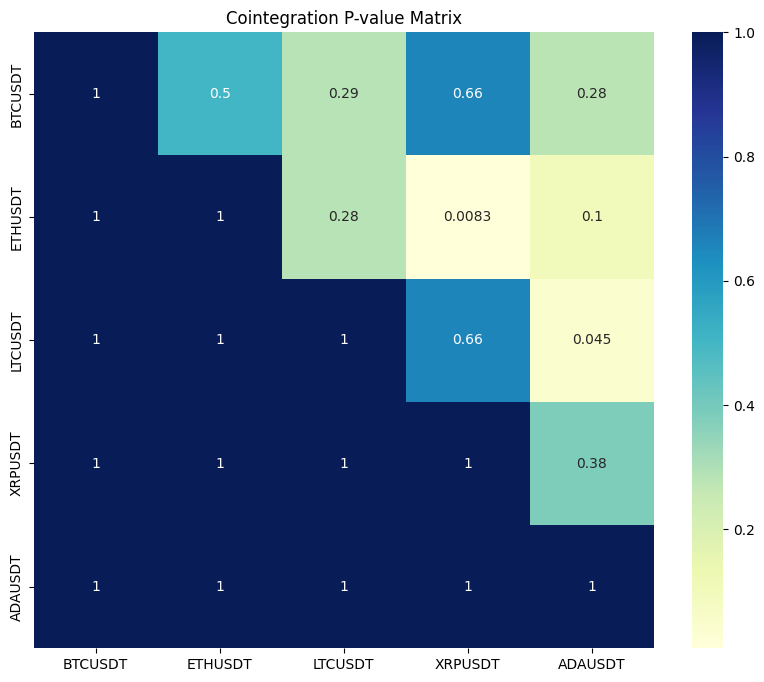


Found Cointegrated Pairs:
Pair: ETHUSDT and XRPUSDT, P-value: 0.0083
Pair: LTCUSDT and ADAUSDT, P-value: 0.0454


In [7]:
print("Cointegration Test P-value Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, xticklabels=pvalue_matrix.columns, yticklabels=pvalue_matrix.columns, cmap='YlGnBu', annot=True)
plt.title('Cointegration P-value Matrix')
plt.show()

print("\nFound Cointegrated Pairs:")
for pair in cointegrated_pairs:
    print(f"Pair: {pair[0]} and {pair[1]}, P-value: {pair[2]:.4f}")

## Other Utility Functions

In [15]:
# px is expected to have data for every 4 hours
def get_horizon_to_px(px_df):
    start_time = px_df.index[0]
    end_time = px_df.index[-1]
    return {
        4: px_df,
        8: px_df[px_df.index.hour % 8 == 0],
        12: px_df[px_df.index.hour % 12 == 0],
        24: px_df[px_df.index.hour == 0],
        48: px_df[px_df.index.hour == 0].loc[pd.date_range(start=start_time, end=end_time, freq='2D')],
    }


def get_cointegrated_pairs_with_window(
    training_px,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
):
    time_to_cointegrated_pairs = dict()
    df_index = training_px.index
    for index in range(0, len(training_px), num_periods_between_recalculation):
        look_back_index = max(0, index - num_look_back_periods)
        if look_back_index == 0:
            continue
        input_px = training_px.iloc[look_back_index:index]
        
        time_to_cointegrated_pairs[df_index[index]] = find_cointegrated_pairs(input_px, significance_level)[1]
    return time_to_cointegrated_pairs


# forward fill the indices from time_series_index with the values in time_map based on
# the most recent key from time_map.
def fill_time_map(time_map, time_series_index):
    all_times_to_coint_pairs = dict()
    if len(time_map) == 0:
        return all_times_to_coint_pairs
    
    sorted_keys = sorted(list(time_map.keys()))
    sorted_keys_index = None

    for index in range(len(time_series_index)):
        current_time = time_series_index[index]

        if sorted_keys_index is None and current_time >= sorted_keys[0]:
            sorted_keys_index = 0
        while sorted_keys_index is not None and ((sorted_keys_index + 1) < len(sorted_keys)) and current_time >= sorted_keys[sorted_keys_index + 1]:
            sorted_keys_index += 1

        if sorted_keys_index is not None:
            all_times_to_coint_pairs[current_time] = time_map[sorted_keys[sorted_keys_index]]
        else:
            all_times_to_coint_pairs[current_time] = []
    
    return all_times_to_coint_pairs


def calculate_alpha_beta_at_index(px_df, index, num_look_back_periods, dependent_coin, independent_coin):
    start_index = max(0, index - num_look_back_periods)
    dependent_data = px_df[dependent_coin].iloc[start_index:index]
    independent_data = px_df[independent_coin].iloc[start_index:index]
    
    alpha, beta = get_alpha_beta_to_asset(dependent_data, independent_data)
    return alpha, beta


def get_times_to_cointegrated_pairs_to_hedges(
    horizon_px_df,
    all_times_to_cointegrated_pairs,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level):
    
    times_to_cointegrated_pairs_to_hedges = dict()
    horizon_px_df_index = horizon_px_df.index
    for index in range(0, len(horizon_px_df), num_periods_between_recalculation):
        current_time = horizon_px_df_index[index]
        times_to_cointegrated_pairs_to_hedges[current_time] = dict()
        
        for independent_coin, dependent_coin, _ in all_times_to_cointegrated_pairs[current_time]:
            times_to_cointegrated_pairs_to_hedges[current_time][
                (independent_coin, dependent_coin)] = calculate_alpha_beta_at_index(
                    horizon_px_df, index, num_look_back_periods, dependent_coin, independent_coin)
    
    return times_to_cointegrated_pairs_to_hedges


def get_raw_signal(all_times_to_coint_pairs, px_df):
    signal_map = dict()

    for index, value in all_times_to_coint_pairs.items():
        signal_row = pd.Series(0.0, index = px_df.columns)

        for (independent_coin, dependent_coin), (alpha, beta) in value.items():
            dependent_coin_estimate = px_df.loc[index, independent_coin] * beta + alpha

            if px_df.loc[index, dependent_coin] >= dependent_coin_estimate:
                # dependent_coin is overvalued relative to independent_coin; short one share of it
                # independent_coin is undervalued relative to dependent_coin; long beta shares of it

                signal_row[independent_coin] += beta
                signal_row[dependent_coin] -= 1.0
            else:
                # dependent_coin is undervalued relative to independent_coin; long one share of it
                # independent_coin is overvalues relative to dependent_coin; short one share of it

                signal_row[independent_coin] -= beta
                signal_row[dependent_coin] += 1.0

        signal_map[index] = signal_row

    return pd.DataFrame(signal_map).T


def get_returns_from_dynamic_cointegration(
    time_horizon_hours,
    horizon_px_df,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
):
    
    time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
        horizon_px_df,
        num_look_back_periods,
        num_periods_between_recalculation,
        significance_level)
    
    all_times_to_cointegrated_pairs = fill_time_map(
        time_to_cointegrated_pairs, horizon_px_df.index)
    
    time_to_cointegrated_pairs_to_hedges = get_times_to_cointegrated_pairs_to_hedges(
        horizon_px_df,
        all_times_to_cointegrated_pairs,
        num_look_back_periods,
        num_periods_between_recalculation,
        significance_level)
    
    all_times_to_cointegrated_pairs_to_hedges = fill_time_map(
        time_to_cointegrated_pairs_to_hedges, horizon_px_df.index)
    
    raw_signal = get_raw_signal(all_times_to_cointegrated_pairs_to_hedges, horizon_px_df)
    transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)
    return get_gross_returns_and_net_returns(transformed_signal, horizon_px_df)


# original_px_df should have data for every 4 hours
def get_all_gross_returns_and_net_returns(original_px_df, num_periods_between_recalculation):
    # return map from variations to pair of dataframes of gross returns and net returns
    variation_to_returns = dict()
    
    horizon_to_px = get_horizon_to_px(original_px_df)
    for time_horizon_hours in (4, 8, 12, 24, 48):
        for significance_level in (0.10, 0.05, 0.02):
            num_look_back_periods = 2 * num_periods_between_recalculation
            
            gross_returns, net_returns = get_returns_from_dynamic_cointegration(
                time_horizon_hours,
                horizon_to_px[time_horizon_hours],
                num_look_back_periods,
                num_periods_between_recalculation,
                significance_level
            )
    
            variation_to_returns[(time_horizon_hours, significance_level)] = net_returns

    return variation_to_returns


def read_and_format_data_frame(csv_file):
    net_return_variations_from_csv = pd.read_csv(csv_file, index_col=0, header = [0, 1])
    net_return_variations_from_csv.rename(lambda c: int(c), axis=1, level=0, inplace=True)

    net_return_variations_from_csv[("open time")] = net_return_variations_from_csv.index

    date_format = "%Y-%m-%d %H:%M:%S"
    net_return_variations_from_csv["open time"] = net_return_variations_from_csv[
        ("open time")].apply(lambda t:  datetime.strptime(t, date_format))
    net_return_variations_from_csv.set_index(("open time"), inplace=True)

    return net_return_variations_from_csv


def plot_gross_and_net_cumulative_returns(gross_returns, net_returns):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Cumulative Return')
    axes[0].grid(True)

    # Plot the second Series on the second subplot (axes[1])
    net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].grid(True)

    # Adjust layout to prevent overlapping titles/labels
    plt.tight_layout()

    # Display the plots
    plt.show()

# Identify And Trade Using Recalculation Period Of 84 Periods

For time series data every 4 hours, this represents 2 weeks.

In [16]:
# Note: this takes a long time to run so it is guarded by an if-statement.

should_run = False

if should_run:
    num_periods_between_recalculation = 6 * 7 * 2

    variation_to_returns_2w = get_all_gross_returns_and_net_returns(
        full_train_px,
        num_periods_between_recalculation
    )
    net_return_variations_2w = pd.DataFrame(variation_to_returns_2w)
    net_return_variations_2w.to_csv('./cointegration_recalculation_2w.csv', index=True)
else:
    net_return_variations_2w_from_csv = read_and_format_data_frame('./cointegration_recalculation_2w.csv')

# Identify And Trade Using Recalculation Period Of 168 Periods

For time series data every 4 hours, this represents 4 weeks.

In [17]:
# Note: this takes a long time to run so it is guarded by an if-statement.

should_run = False

if should_run:
    num_periods_between_recalculation = 6 * 7 * 4

    variation_to_returns_4w = get_all_gross_returns_and_net_returns(
        full_train_px,
        num_periods_between_recalculation
    )
    net_return_variations_4w = pd.DataFrame(variation_to_returns_4w)
    net_return_variations_4w.to_csv('./cointegration_recalculation_4w.csv', index=True)
else:
    net_return_variations_4w_from_csv = read_and_format_data_frame('./cointegration_recalculation_4w.csv')

# Identify And Trade Using Recalculation Period Of 252 Periods

For time series data every 4 hours, this represents 6 weeks.

In [18]:
# Note: this takes a long time to run so it is guarded by an if-statement.

should_run = False

if should_run:
    num_periods_between_recalculation = 6 * 7 * 6

    variation_to_returns_6w = get_all_gross_returns_and_net_returns(
        full_train_px,
        num_periods_between_recalculation
    )
    net_return_variations_6w = pd.DataFrame(variation_to_returns_6w)
    net_return_variations_6w.to_csv('./cointegration_recalculation_6w.csv', index=True)
else:
    net_return_variations_6w_from_csv = read_and_format_data_frame('./cointegration_recalculation_6w.csv')

In [19]:
# # Note: this takes a long time to run so it is guarded by an if-statement.

# should_run = False

# if should_run:
#     num_periods_between_recalculation = 6 * 7 * 8

#     variation_to_returns_8w = get_all_gross_returns_and_net_returns(
#         full_train_px,
#         num_periods_between_recalculation
#     )
#     net_return_variations_8w = pd.DataFrame(variation_to_returns_8w)
#     net_return_variations_8w.to_csv('./cointegration_recalculation_8w.csv', index=True)
# else:
#     net_return_variations_8w_from_csv = read_and_format_data_frame('./cointegration_recalculation_8w.csv')

# Display Stats For All Variants

The best performances were with:
  - Cointegration recalculated every 168 periods, 8-hour time horizon, significance level = 0.02: 1.738776
  - Cointegration recalculated every 252 periods, 8-hour time horizon, significance level = 0.02: 1.738776
  - Cointegration recalculated every 252 periods, 4-hour time horizon, significance level = 0.05: 1.694071

In [20]:
horizon_to_px = get_horizon_to_px(full_train_px)
variant_to_stats = dict()


results = [
    ('2w', net_return_variations_2w_from_csv),
    ('4w', net_return_variations_4w_from_csv),
    ('6w', net_return_variations_6w_from_csv),
]

for freq_label, return_result in results:
    for column in return_result.columns:
        variant_prices = horizon_to_px[int(column[0])]
        variant_to_stats[(freq_label, int(column[0]), column[1])] = get_strategy_stats(
           return_result[column].loc[variant_prices.index], int(column[0]), variant_prices)


all_output_stats = pd.DataFrame(variant_to_stats).T.sort_values(by=["sharpe ratio"], ascending=False)
all_output_stats

avg returns  decorrelated avg returns  volatility  sharpe ratio  \
4w 8  0.02     0.325232                  0.320801    0.187046      1.738776   
6w 8  0.02     0.325232                  0.320801    0.187046      1.738776   
   4  0.05     0.372004                  0.374898    0.219592      1.694071   
4w 4  0.05     0.372004                  0.374898    0.219592      1.694071   
2w 12 0.1      0.284386                  0.273365    0.169890      1.673936   
4w 8  0.05     0.278557                  0.265570    0.190824      1.459762   
6w 8  0.05     0.278557                  0.265570    0.190824      1.459762   
2w 12 0.05     0.233866                  0.225753    0.168735      1.386001   
6w 4  0.1      0.289685                  0.289237    0.211033      1.372701   
4w 4  0.1      0.289685                  0.289237    0.211033      1.372701   
6w 8  0.1      0.239034                  0.228019    0.189502      1.261379   
4w 8  0.1      0.239034                  0.228019    0.189502      1.261379   
2w 12 0.02     0.218628                  0.217444    0.177288      1.233177   
6w 24 0.05     0.089014                  0.094827    0.086020      1.034810   
4w 24 0.05     0.089014                  0.094827    0.086020      1.034810   
6w 4  0.02     0.250778                  0.251518    0.244732      1.024704   
4w 4  0.02     0.250778                  0.251518    0.244732      1.024704   
2w 8  0.05     0.208173                  0.207075    0.205416      1.013422   
      0.1      0.187687                  0.189889    0.196049      0.957348   
4w 24 0.1      0.074528                  0.083413    0.084786      0.879018   
6w 24 0.1      0.074528                  0.083413    0.084786      0.879018   
2w 8  0.02     0.187126                  0.193048    0.222106      0.842511   
6w 24 0.02     0.070619                  0.079882    0.088707      0.796096   
4w 24 0.02     0.070619                  0.079882    0.088707      0.796096   
   12 0.1      0.098702                  0.104656    0.126048      0.783051   
6w 12 0.1      0.098702                  0.104656    0.126048      0.783051   
      0.05     0.087213                  0.088168    0.130150      0.670092   
4w 12 0.05     0.087213                  0.088168    0.130150      0.670092   
2w 4  0.1      0.143761                  0.157080    0.224632      0.639982   
4w 12 0.02     0.078005                  0.081218    0.137048      0.569179   
6w 12 0.02     0.078005                  0.081218    0.137048      0.569179   
2w 24 0.1      0.063262                  0.068704    0.125111      0.505649   
4w 48 0.1      0.010400                  0.011098    0.021067      0.493657   
6w 48 0.1      0.010400                  0.011098    0.021067      0.493657   
2w 24 0.05     0.061001                  0.061826    0.123710      0.493096   
   48 0.1      0.033529                  0.043391    0.087941      0.381265   
      0.05     0.031870                  0.042124    0.085866      0.371159   
   24 0.02     0.042339                  0.037317    0.125307      0.337879   
   48 0.02     0.026659                  0.036281    0.089248      0.298705   
   4  0.05     0.048666                  0.063996    0.225312      0.215992   
4w 48 0.02     0.004660                  0.005225    0.022335      0.208654   
6w 48 0.02     0.004660                  0.005225    0.022335      0.208654   
2w 4  0.02     0.050294                  0.054650    0.248187      0.202644   
4w 48 0.05     0.003419                  0.004334    0.022701      0.150612   
6w 48 0.05     0.003419                  0.004334    0.022701      0.150612   

            decorrelated sharpe ratio  max drawdown  max drawdown duration  \
4w 8  0.02                   1.716097     -1.853337             661.666667   
6w 8  0.02                   1.716097     -1.853337             661.666667   
   4  0.05                   1.707486    -17.930030             816.166667   
4w 4  0.05                   1.707486    -17.930030             8

# Top Variations Run During Testing Period

In [ ]:
horizon_to_px = get_horizon_to_px(px)

## Time Horizon = 8 hours, Recalculation Every 6 * 7 * 4 Periods, Significance = 0.02

In [22]:
time_horizon_hours = 8
num_periods_between_recalculation = 6 * 7 * 4
num_look_back_periods = 2 * num_periods_between_recalculation
significance_level = 0.02

gross_returns, net_returns = get_returns_from_dynamic_cointegration(
    time_horizon_hours,
    horizon_to_px[time_horizon_hours],
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
)

In [30]:
test_gross_returns = gross_returns.loc[t:]
test_net_returns = net_returns.loc[t:]

raw_stats = get_strategy_stats(test_net_returns, time_horizon_hours, horizon_to_px[time_horizon_hours].loc[t:])
pd.Series(raw_stats).to_frame()

,0
avg returns,0.977375
decorrelated avg returns,0.993079
volatility,0.157488
sharpe ratio,6.206020
decorrelated sharpe ratio,6.330768
max drawdown,-1.908099
max drawdown duration,81.666667
alpha_BTC,0.000907
beta_BTC,-0.027977


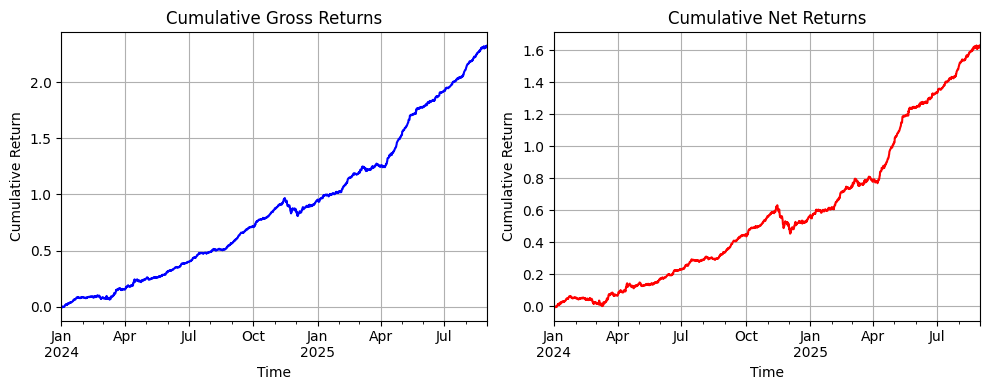

In [31]:
plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)

## Time Horizon = 8 hours, Recalculation Every 6 * 7 * 6 Periods, Significance = 0.02

In [ ]:
time_horizon_hours = 8
num_periods_between_recalculation = 6 * 7 * 6
num_look_back_periods = 2 * num_periods_between_recalculation
significance_level = 0.02

gross_returns, net_returns = get_returns_from_dynamic_cointegration(
    time_horizon_hours,
    horizon_to_px[time_horizon_hours],
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
)

In [33]:
test_gross_returns = gross_returns.loc[t:]
test_net_returns = net_returns.loc[t:]

raw_stats = get_strategy_stats(test_net_returns, time_horizon_hours, horizon_to_px[time_horizon_hours].loc[t:])
pd.Series(raw_stats).to_frame()

,0
avg returns,0.975243
decorrelated avg returns,0.980810
volatility,0.156553
sharpe ratio,6.229492
decorrelated sharpe ratio,6.265141
max drawdown,-4.816111
max drawdown duration,31.666667
alpha_BTC,0.000893
beta_BTC,-0.004918


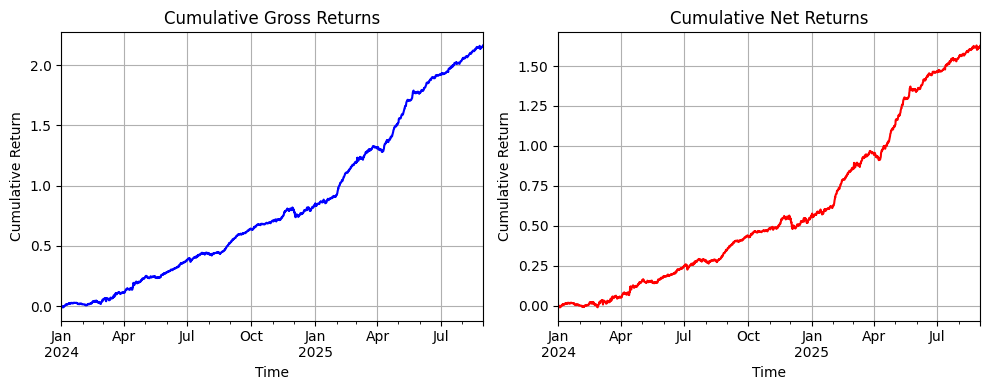

In [34]:
plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)

## Time Horizon = 4 hours, Recalculation Every 6 * 7 * 6 Periods, Significance = 0.05

In [ ]:
time_horizon_hours = 4
num_periods_between_recalculation = 6 * 7 * 6
num_look_back_periods = 2 * num_periods_between_recalculation
significance_level = 0.05

gross_returns, net_returns = get_returns_from_dynamic_cointegration(
    time_horizon_hours,
    horizon_to_px[time_horizon_hours],
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
)

In [37]:
test_gross_returns = gross_returns.loc[t:]
test_net_returns = net_returns.loc[t:]

raw_stats = get_strategy_stats(test_net_returns, time_horizon_hours, horizon_to_px[time_horizon_hours].loc[t:])
pd.Series(raw_stats).to_frame()

,0
avg returns,1.456616
decorrelated avg returns,1.474618
volatility,0.157680
sharpe ratio,9.237782
decorrelated sharpe ratio,9.381594
max drawdown,-1.503441
max drawdown duration,29.833333
alpha_BTC,0.000673
beta_BTC,-0.026089


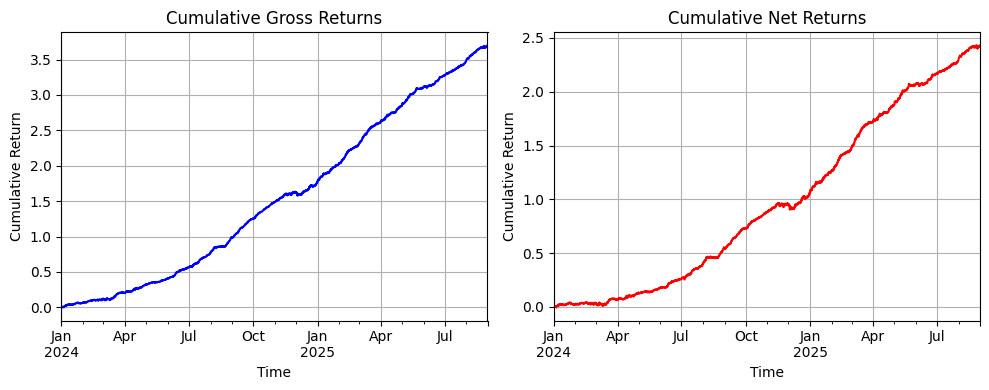

In [38]:
plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)